In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [11]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 100        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0     # regularization. Increase this to combat overfitting

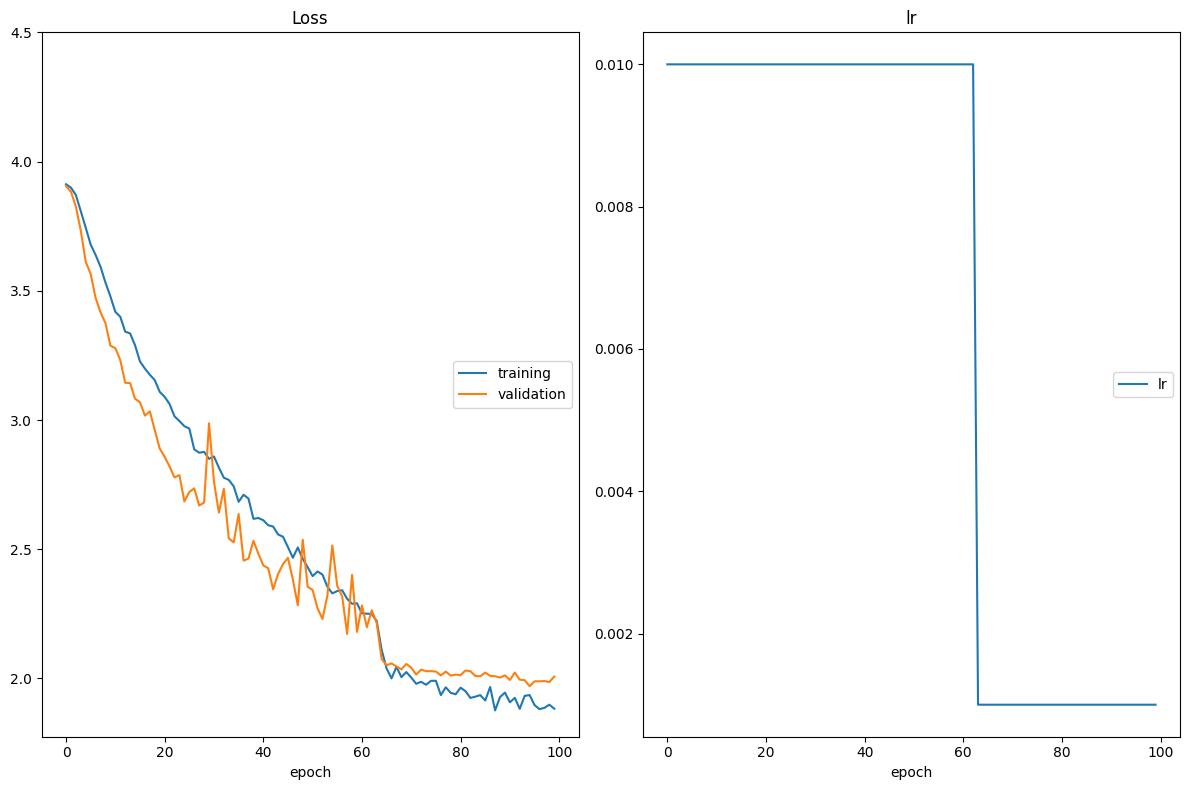

In [6]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# Get the data loaders using batch_size and valid_size defined in the previous cell
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size, num_workers=-1)

# Instantiate the model MyModel with num_classes and dropout defined in the previous cell
model = MyModel(num_classes=num_classes, dropout=dropout)

# Get the optimizer using get_optimizer and the model you just created,
# the learning rate, the optimizer, and the weight decay specified in the previous cell
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)

# Get the loss using get_loss
loss = get_loss()

# Start the optimization process using the optimize function
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

In [14]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# Get the data loaders using batch_size and valid_size defined in the previous cell
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size, num_workers=-1)

# Instantiate the model MyModel with num_classes and dropout defined in the previous cell
model = MyModel(num_classes=num_classes, dropout=dropout)

# Get the optimizer using get_optimizer and the model you just created,
# the learning rate, the optimizer, and the weight decay specified in the previous cell
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)

# Get the loss using get_loss
loss = get_loss()

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])


In [15]:
from src.train import one_epoch_test
from src.model import MyModel
import torch
import pyperclip as clip


model = MyModel(num_classes=num_classes, dropout=dropout)

# Load the weights from 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run the test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:10<00:00,  1.86it/s]

Test Loss: 1.946922


Test Accuracy: 50% (636/1250)


1.9469215095043184

In [6]:
pip install pyperclip


  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11123 sha256=4f71da8af5918b080db27ff235e0423aae30bd9a45a794ca7c11986ee9ef5060
  Stored in directory: /root/.cache/pip/wheels/04/24/fe/140a94a7f1036003ede94579e6b4227fe96c840c6f4dcbe307
Successfully built pyperclip


In [9]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

checkpoint_path = '/content/checkpoints/best_val_loss.pt'
checkpoint = torch.load(checkpoint_path)
import pyperclip as clip

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor =  torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")
import pyperclip as clip

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


In [18]:
import torch

# Load using torch.jit.load
model_reloaded =  torch.jit.load("checkpoints/original_exported.pt")

In [19]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

  0%|                                          | 1/1250 [00:00<04:06,  5.06it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %390 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weigh

Accuracy: 0.02


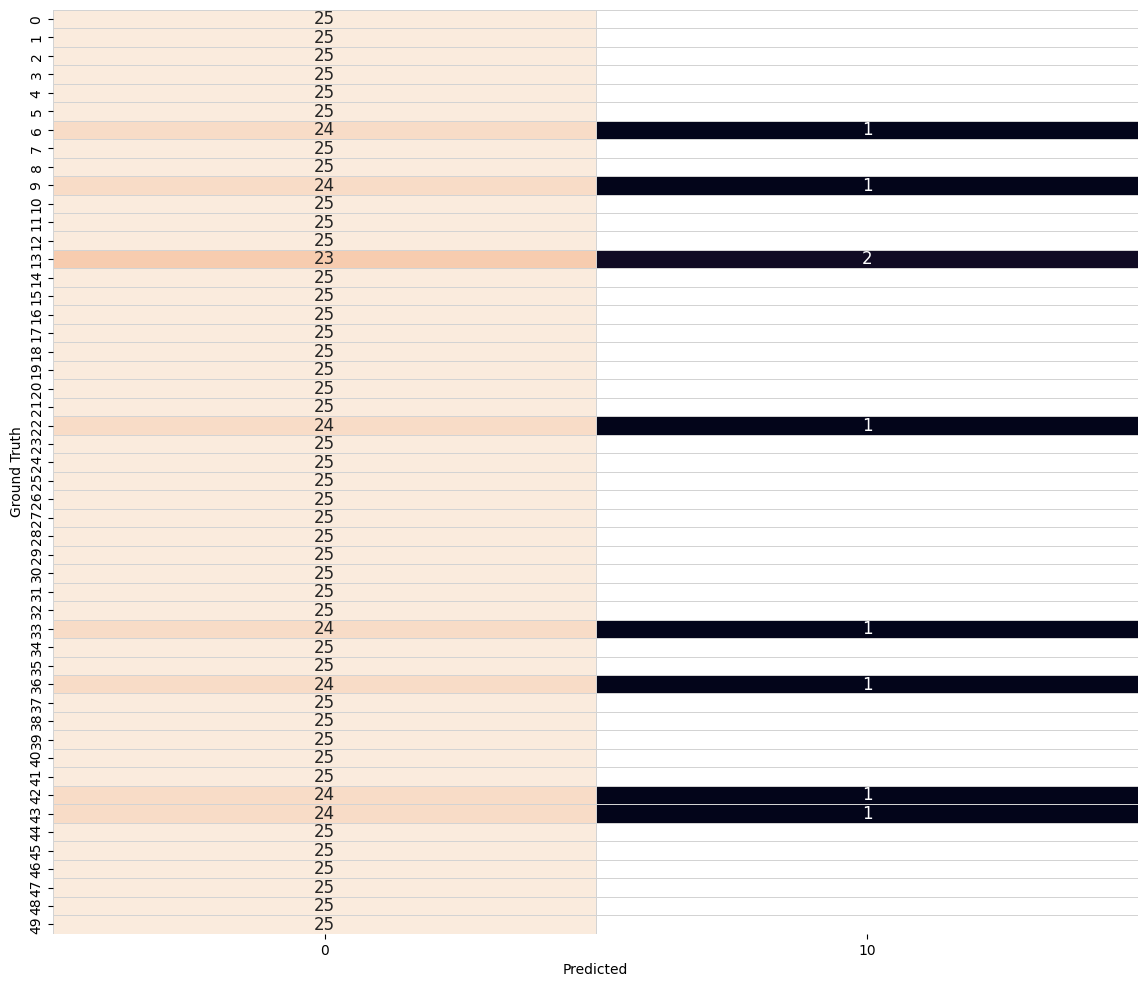

In [21]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)